In this notebook we want to figure out if a SIREN compared to a NN overfits. We use our baseline dataset and check the MSE and regression:

In [1]:
# General imports
import numpy as np
import torch

# DeepMoD Components
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN, Siren
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training import train
from multitaskpinn.training.sparsity_scheduler import Periodic

# Data
from phimal_utilities.data import Dataset
from phimal_utilities.data.kdv import DoubleSoliton

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

In [2]:
# Making data
x = np.linspace(-7, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=(5, 2), x0=(-3, -1))


X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=False, random=False)

Text(0, 0.5, 't')

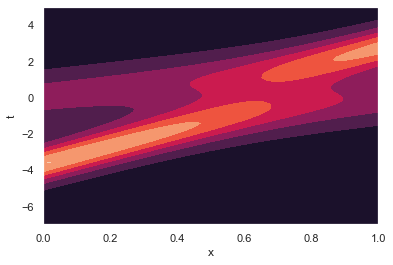

In [3]:
plt.contourf(t_grid, x_grid, y_full.reshape(x_grid.shape))
plt.xlabel('x')
plt.ylabel('t')

In [4]:
# Making training set
x_sample = np.linspace(-7, 5, 50)
t_sample = np.linspace(0.0, 1.0, 40)
x_grid_sample, t_grid_sample = np.meshgrid(x_sample, t_sample, indexing='ij')
X_train, y_train = dataset.create_dataset(x_grid_sample.reshape(-1, 1), t_grid_sample.reshape(-1, 1), n_samples=0, noise=0.1, normalize=True, random=True)

So our MSE should be the following to not overfit:

In [9]:
MSE_min = ((0.1 * torch.std(y_train))**2).numpy()

In [10]:
MSE_min

array(0.00412252, dtype=float32)

# NN

In [13]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model_NN = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=10000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model_NN.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [14]:
train(model_NN, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/NN_long_no_sparsity/', max_iterations=5000, delta=0.0) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       5000    100.00%               0s   -7.29e+00   4.15e-03   1.49e-05   3.25e+00 

# SIREN

In [15]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model_siren = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=10000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model_siren.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [16]:
train(model_siren, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs/SIREN_long_no_sparsity/', max_iterations=5000, delta=0.0) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       3325     66.50%             112s   -7.33e+00   4.05e-03   3.95e-05   3.58e+00 

KeyboardInterrupt: 

# Analysis